In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from asi import path_config

session2 = path_config.measurements / "session2"

In [2]:
from asi.draw import reconstruct_rgb_envi
from asi.preprocess import load_white_corrected

specim_iq = session2 / "Specim scanner" / "PowdersIR" / "capture"

image_path = specim_iq / "IR_scan_0462"
darkref_path = specim_iq / "DARKREF_IR_scan_0462"
whiteref_path = specim_iq / "WHITEREF_IR_scan_0462"

spectral_image, envi_header = load_white_corrected(image_path, whiteref_path, darkref_path)
spectral_image = spectral_image.astype(np.float16)

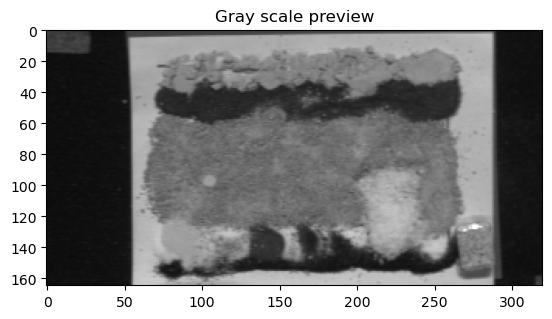

In [3]:
from segmentation import reconstruct_gray_rgb

rgb_view = reconstruct_gray_rgb(spectral_image)
plt.imshow(rgb_view, cmap="gray")
plt.title("Gray scale preview")
plt.show()

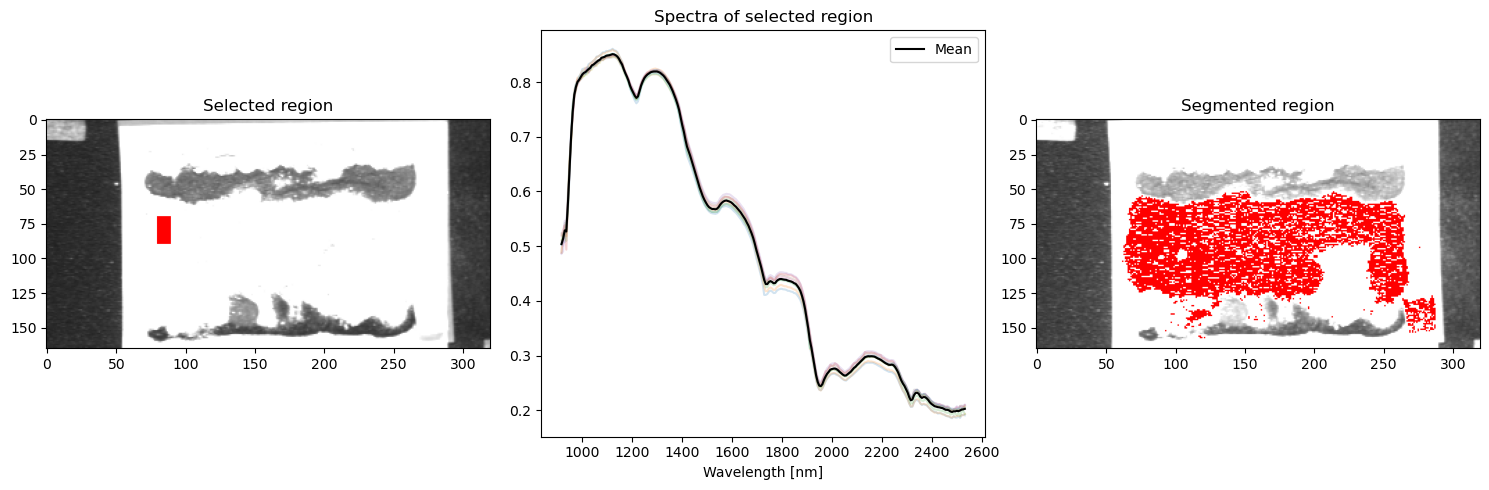

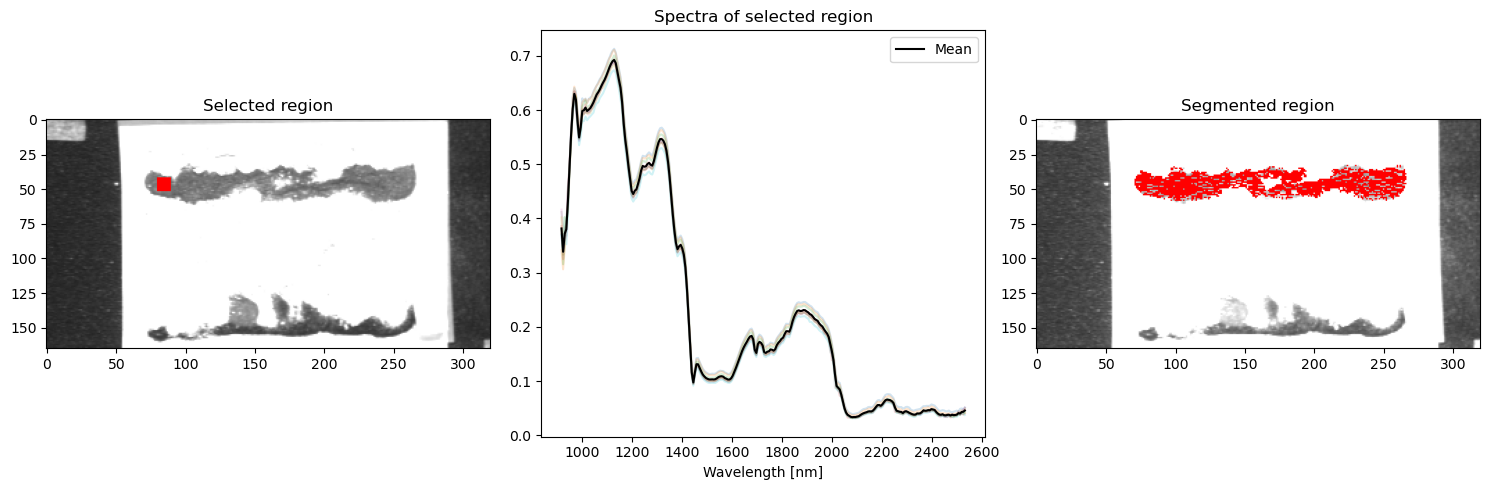

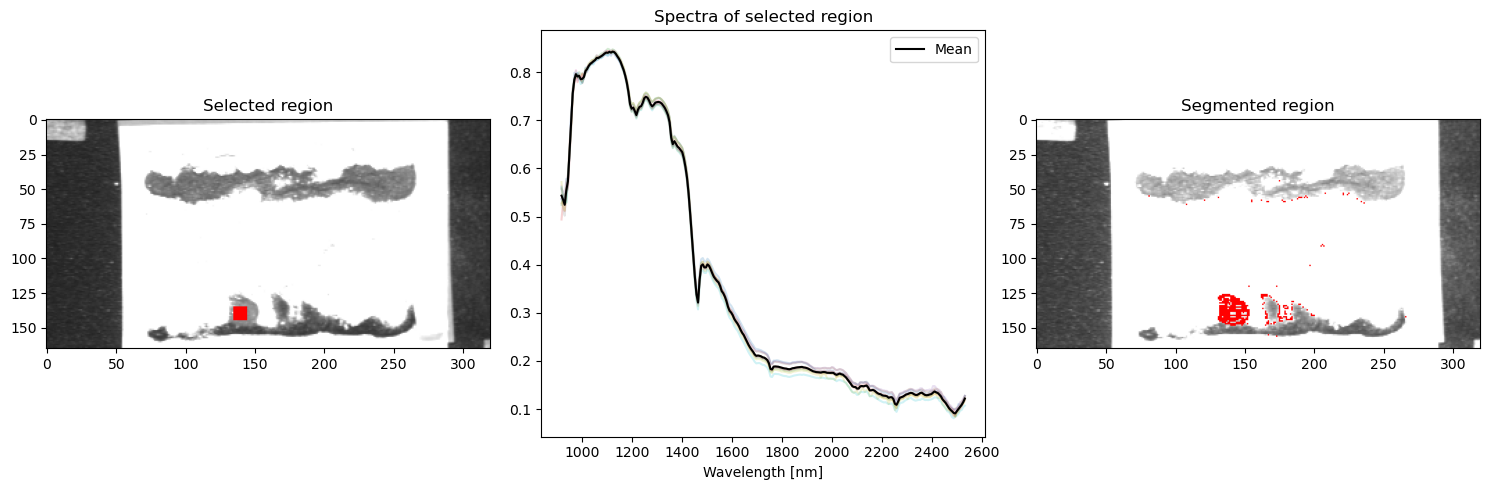

In [4]:
from segmentation import plot_segmentation_results

threshold = 0.15
pos = slice(70, 90), slice(80, 90)
fig = plot_segmentation_results(spectral_image, envi_header, pos, use_gray=True, threshold=threshold)
plt.show()

pos = slice(42, 52), slice(80, 90)
fig = plot_segmentation_results(spectral_image, envi_header, pos, use_gray=True, threshold=threshold)
plt.show()

pos = slice(135, 145), slice(135, 145)
fig = plot_segmentation_results(spectral_image, envi_header, pos, use_gray=True, threshold=threshold)
plt.show()

Text(0.5, 1.0, 'RGB preview')

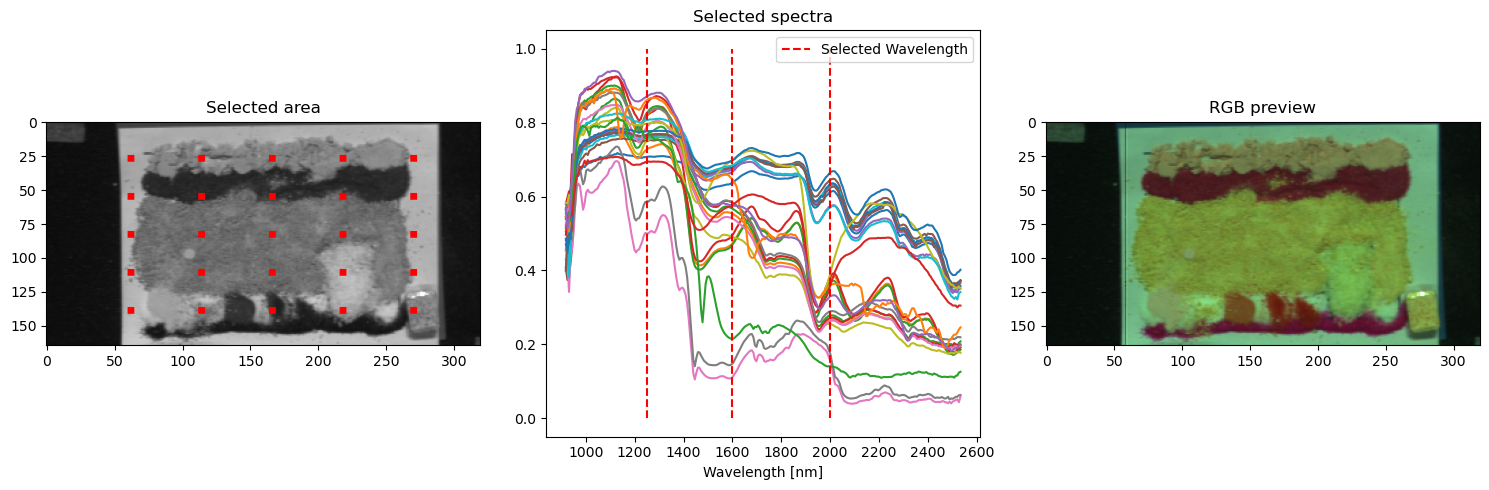

In [5]:
from asi.utils import get_wavelengths
from segmentation import select_area


fig, axes = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
square_rgb_view_ax = axes[0]
spectra_ax = axes[1]
rgb_ax = axes[2]

xmin = 25
ymin = 60
xmax, ymax = spectral_image.shape[:2]

pix_size = 5

wavelengths = get_wavelengths(envi_header)

selected_spectra_list = []

square_rgb_view = rgb_view.copy()
nb = 5
xstep = (xmax - xmin) // nb
ystep = (ymax - ymin) // nb
for x in range(xmin, xmax, xstep):
    for y in range(ymin, ymax, ystep):
        pos = slice(x, x + pix_size), slice(y, y + pix_size)
        square_rgb_view = select_area(square_rgb_view, pos)
        selected_area = spectral_image[pos]
        selected_spectra = spectral_image[pos].mean(axis=(0, 1))
        selected_spectra_list.append(selected_spectra)
        spectra_ax.plot(wavelengths, selected_spectra)

selected_spectra_list = np.array(selected_spectra_list)
stds = selected_spectra_list.std(axis=1)
top_3_indices = np.argsort(stds)[:3]#[::-1]

square_rgb_view_ax.imshow(square_rgb_view)
square_rgb_view_ax.set_title("Selected area")

r = 1250
g = 1600
b = 2000
# r_idx, g_idx, b_idx = top_3_indices
# r = wavelengths[r_idx]
# g = wavelengths[g_idx]
# b = wavelengths[b_idx]


spectra_ax.vlines([r, g, b], 0, 1, colors="r", linestyles="dashed", label="Selected Wavelength")
spectra_ax.set_title("Selected spectra")
spectra_ax.set_xlabel("Wavelength [nm]")
spectra_ax.legend()

rgb_view = reconstruct_rgb_envi(spectral_image, envi_header, (r, g, b))
rgb_view *= 1.5
rgb_view = rgb_view.clip(0, 1)
rgb_ax.imshow(rgb_view)
rgb_ax.set_title("RGB preview")